In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

%matplotlib inline
from IPython.display import clear_output

import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.utils.prune as prune

In [ ]:
"""
The following function globally prunes all weights (not including the bias vectors) 
in nn.Linear layers in the model using L1 unstructured pruning,
reinitializes the surviving weights using Kaiming uniform initialization,
and installs a forward pre-hook to enforce that the pruned weights remain zero.

Inputs:
    model (nn.Module): The model to prune.
    amount (float): Fraction of weights to prune globally (e.g., 0.8 for 80%).

Output: The pruned model.
"""
def global_prune(model, amount):
    # Collect all Linear layers and their weights
    parameters_to_prune = [
        (module, 'weight') 
        for module in model.modules()
        if isinstance(module, nn.Linear)
    ]

    # Perform global L1 unstructured pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    # Process each pruned layer
    for module, param_name in parameters_to_prune:
        # Extract and store mask as buffer
        mask = getattr(module, f"{param_name}_mask").clone()
        module.register_buffer("pruning_mask", mask)
        
        # Reinitialize unpruned weights while preserving zeros
        with torch.no_grad():
            # Get current weights (already pruned)
            weight = getattr(module, param_name)
            
            # Create new initialization
            new_weights = torch.empty_like(weight)
            nn.init.kaiming_uniform_(new_weights, mode='fan_in', nonlinearity='relu')
            
            # Apply mask and update weights
            weight.data.copy_(new_weights * mask)

        # Remove PyTorch's pruning buffers
        prune.remove(module, param_name)

    # Register forward pre-hook to maintain pruning
    def apply_mask(module, inputs):
        if hasattr(module, "pruning_mask"):
            mask = module.pruning_mask
            with torch.no_grad():
                module.weight.data.mul_(mask)  # In-place multiplication

    # Add hooks to all pruned modules
    for module, _ in parameters_to_prune:
        if hasattr(module, "pruning_mask"):
            module.register_forward_pre_hook(apply_mask)

    return model

In [41]:
n = 2*10**4    # This includes training data, validationm data and testing data. 
d = 20
sigma = 0.5

# Define regression function
def reg_func(x):
    y = np.exp(x[1] + x[2]) + 4 * x[3]**2    # X unif[-1,1], Bayes risk approx 1.448286 + sigma^2
    return y

# Generate X and Y
X = np.random.uniform(-1 , 1, (n, d))
epsilon = np.random.normal(0, sigma, n)
Y = np.zeros(n)
for i in range(n):
    Y[i] = reg_func(X[i,:]) + epsilon[i]

# Generate Omega, which has iid Ber(0.5) coordinates, independent of X
Omega = np.random.binomial(1, 0.5, (n, d))
Z_ZI = X * Omega

In [42]:
# Split data into 50% training data, 25% validation data, 25% testing data
Z_ZI_train = Z_ZI[0:int(n/2), :]
Z_ZI_val = Z_ZI[int(n/2):int(3*n/4), :]
Z_ZI_test = Z_ZI[int(3*n/4):n, :]
Omega_train = Omega[0:int(n/2), :]
Omega_val = Omega[int(n/2):int(3*n/4), :]
Omega_test = Omega[int(3*n/4):n, :]
Y_train = Y[0:int(n/2)]
Y_val = Y[int(n/2):int(3*n/4)]
Y_test = Y[int(3*n/4):n]

# Convert data into tensors
Z_ZI_train = torch.tensor(Z_ZI_train, dtype=torch.float32)
Z_ZI_val = torch.tensor(Z_ZI_val, dtype=torch.float32)
Z_ZI_test = torch.tensor(Z_ZI_test, dtype=torch.float32)
Omega_train = torch.tensor(Omega_train, dtype=torch.float32)
Omega_val = torch.tensor(Omega_val, dtype=torch.float32)
Omega_test = torch.tensor(Omega_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)
Y_val = torch.tensor(Y_val.reshape(-1, 1), dtype=torch.float32)
Y_test = torch.tensor(Y_test.reshape(-1, 1), dtype=torch.float32)

In [43]:
# Define the class of Pattern Embedding Neural Networks (PENN)
class PENN(nn.Module):
    def __init__(self):
        super().__init__()
        embedding_dim = 5
        
        # Construct the neural network f2
        self.f2 = nn.Sequential(
            nn.Linear(d, 70),  
            nn.ReLU(),
            nn.Linear(70, 70), 
            nn.ReLU(),
            nn.Linear(70, 70), 
            nn.ReLU()
        )

        # Construct the neural network f3, i.e. the embedding function
        self.f3 = nn.Sequential(
            nn.Linear(d, 30),  
            nn.ReLU(),
            nn.Linear(30, 30),  
            nn.ReLU(),
            nn.Linear(30, 30),  
            nn.ReLU(),
            nn.Linear(30, embedding_dim)
        )

        
        # Construct the neural network f1
        self.f1 = nn.Sequential(
            nn.Linear(70 + embedding_dim, 70),
            nn.ReLU(),
            nn.Linear(70, 70),
            nn.ReLU(),
            nn.Linear(70, 70),
            nn.ReLU(),
            nn.Linear(70, 1)  
        )
    
    # Combine f1, f2 and f3 to construct the Pattern Embedding Neural Network
    def forward(self, z, omega):
        # Compute the output of f2 and f3
        f2_output = self.f2(z)
        f3_output = self.f3(omega)
        
        # Concatenate the output of f2 and f3
        combined_features = torch.cat((f2_output, f3_output), dim=1)
        
        # Apply the combined network
        final_output = self.f1(combined_features)
        
        return final_output

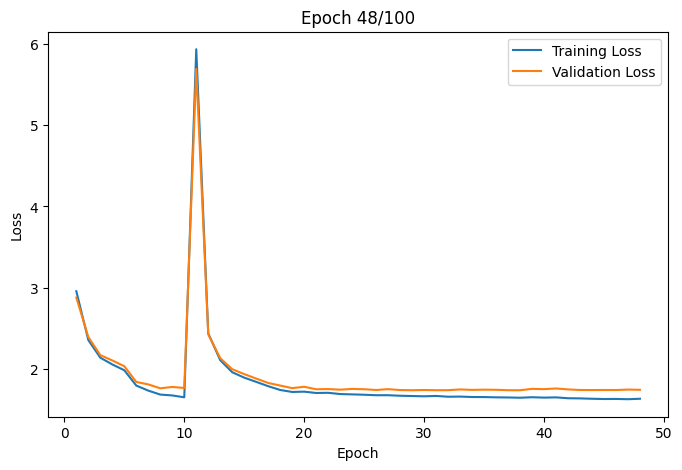

Early stopping triggered at epoch 48.
Excess risk: 0.10192465782165527


In [ ]:
lr = 0.001
epochs = 100
patience = 10
threshold = 0.001

model_PENN = PENN()
PENN_train_data = TensorDataset(Z_ZI_train, Omega_train, Y_train)
PENN_train_loader = DataLoader(dataset = PENN_train_data, batch_size=200, shuffle=True)

optimizer = optim.Adam(model_PENN.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train_losses = []
val_losses = []

for epoch in range(epochs):

    model_PENN.train()
    if epoch == 10:
        model_PENN = global_prune(model_PENN, amount = 0.9)
        optimizer = optim.Adam(model_PENN.parameters(), lr=lr)
    for z_batch, omega_batch, y_batch in PENN_train_loader:
        optimizer.zero_grad()
        pred = model_PENN(z_batch, omega_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        
    # Record training and validation losses
    model_PENN.eval()
    with torch.no_grad():
        train_losses.append(loss_fn(model_PENN(Z_ZI_train, Omega_train), Y_train))
        val_losses.append(loss_fn(model_PENN(Z_ZI_val, Omega_val), Y_val))

    # Live plotting (Jupyter only)
    clear_output(wait=True)  
    plt.figure(figsize=(8, 5))
    plt.plot(range(1,epoch+2), train_losses, label='Training Loss')
    plt.plot(range(1,epoch+2), val_losses, label='Validation Loss')
    plt.title(f'Epoch {epoch+1}/{epochs}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Early stopping
    if epoch >= 10:
        min_index = val_losses.index(min(val_losses[10:]))
        if epoch - min_index >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}.')
            break
 

# Print excess risk, i.e. testing loss - bayes risk
model_PENN.eval()
print(f'Excess risk: {loss_fn(model_PENN(Z_ZI_test, Omega_test), Y_test) - 1.448 - sigma**2}')

In [48]:
# Check sparsity
l0_norm = 0
for param in model_PENN.parameters():
    l0_norm += torch.sum(param != 0)
total_param = sum(p.numel() for p in model_PENN.parameters())
print(l0_norm/total_param)

tensor(0.1158)
